# COGS 108 - Final Project 

# Overview

Fast food restaurants are notorious for their uncleanliness and poor sanitation in comparison to other restaurants, at least as depicted by today's media. At the same time, one would expect an area of higher income and affluence to expect a higher level of sanitation and cleanliness. My project aims to aid health inspectors by potentially identifying any correlation between a city's income level and the health inspection scores its restaurants receive.

# Name & PID

- Name: Neil Tengbumroong
- PID: A14395411

# Research Question

In wealthy neighborhoods, do fast food restaurants tend to score higher on health inspections compared to those in poorer neighborhoods?

## Background and Prior Work

Restaurant health inspections are scored on a 100 point scale, with a letter grade being assigned at the conclusion of the inspection (1). Starting from 100, restaurants can be deducted anywhere between one point for a minor infraction, such as proper produce cleaning, to 4 points for a lack of hot water (1). A potential drawback for this project is that many restaurants often have inaccurate scores due to a flawed rating system because not enough points are assigned to serious and health-threatening infractions (1). On the same note, a near perfect restaurant with one major health violation can be shut down, while another restaurant receiving a lower score with more violations can still be allowed to operate (2).

In Oklahoma County, six McDonald's restaurants (of the 17 overall restaurants closed in Oklahoma) close to or south of the dividing I-40 line were shut down (3). This is useful for the research because a specific area showed a poor health trend. 

From the same article as above, several different franchises were inspected and their scores were averaged (3). Standalone KFC and Taco Bell scored well, at below an average of one infraction per franchise, while interestingly enough KFC/Taco Bell combinations had an average of 3.75 combinations (3). This is important, as possible skews from restaurants that in general tend to perform lower may impact the city's overall rating. For example, a city with multiple "bad" restaurants may score lower than a city of similar income with none of those "bad" restaurants.

A very similar research idea was carried out, examining the restaurant's service scores with respect to the income of the area, rather than health inspection scores. Ultimately, however, there was no correlation found between income and restaurant ratings (4).

***Our research will focus on a centralized portion of North Carolina - namely the capital, Raleigh, and its surrounding areas.***


References (include links):
- 1) https://www.sgvtribune.com/2015/06/25/what-that-restaurant-letter-grade-isnt-telling-you-about-health-and-cleanliness/
- 2) http://publichealth.lacounty.gov/eh/misc/ehpost.htm
- 3) https://oklahoman.com/article/1423275/fast-food-chains-vary-in-health-department-scores
- 4) https://medium.com/swlh/is-there-a-correlation-between-a-restaurants-ratings-and-the-income-levels-of-a-neighborhood-5fe41165e4f1

# Hypothesis


My hypothesis is that because affluent neighborhoods tend to attract wealthier customers who expect a higher level of cleanliness and have higher standards to maintain, fast food restaurants in wealthier neighborhoods should score higher in health inspections compared to their counterparts in lower income areas. 

# Dataset(s)

- Dataset Name: zipcodes.csv
- Link to the dataset: (given)
- Number of observations: 38


- Dataset Name: inspections.csv
- Link to the dataset: (given)
- Number of observations: 18466

# Setup

To begin our research, we import all of our necessary packages, as well as the datasets we are going to use into their respective dataframes.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [2]:
df_inspections = pd.read_csv('data/inspections.csv')
df_zipcodes = pd.read_csv('data/zipcodes.csv')

# Data Cleaning

Describe your data cleaning steps here.

I want to correlate the zip codes in our zipcodes dataframe to the zip codes in our inspections dataframe, so that we can associate the restaurant performance of an area to its income. Let's find out how many we can correlate between the two by first determining how many unique zip codes there are.

Then, I want to make sure that they are comparable, and that we are dealing with zip codes that pertain to the same area to begin with (if none of them matched, then taking further action would these datasets would be pointless!)

In [3]:
len(df_zipcodes['zip'].unique())
len(df_inspections['postalcode'].unique())

print(type(df_zipcodes.at[1, 'zip']))
print(type(df_inspections.at[1, 'zip']))

<class 'numpy.int64'>
<class 'numpy.int64'>


Looks like they are the same type, so we can compare them! Now let's we see how many zip codes we have in common, to determine if these are valid datasets we can use. 

In [4]:
print(len(df_inspections['zip'].unique()))
print(len(df_zipcodes['zip'].unique()))

51
38


In [5]:
len(np.intersect1d(df_zipcodes['zip'].unique(), df_inspections['zip'].unique()))

37

37 different zipcode observations should be good enough for our project. Let's continue!

Now the tricky part is to distinguish just the fast food restaurants. I am thinking about a lot of different ways to do this, including using the yelp dataframe and categorizing by price or by type of cuisine. However, there are far too many outliers to account for, such as a brunch place that serves cheap food (only 1 '$' on yelp) or a gourmet burger place that probably shouldn't be classified as fast food. Instead, I've decided to make a generic set of the most popular franchises*, and to use only the restaurants that are included in that set.

*according to https://www.qsrmagazine.com/content/ranking-top-50-fast-food-chains-america

In [6]:
fast_food_list = ['taco bell', 'mcdonald', 'subway', 'burger king', 'quiznos sub', 'starbucks', 'kfc', 'chick-fil-a', 'chipotle', "wendy's", "cici's", 'pizza hut', 'five guys', 'arby', 'popeyes', 'dairy queen', 'little caesars', 'papa johns', 'dunkin', 'sonic', 'domino', 'panda express', 'baskin', "church's", 'auntie anne', 'shake', 'checker', 'jimmy john', 'bojangle', 'firehouse', 'hardee', 'jersey mike', 'papa murphy', 'tim horton', 'del taco', 'white castle']

Before I can begin, I have to normalize the data, because some names are listed as 'SUBWAY' and others as 'Subway', for example. Some even contain a number after their name. I decided to convert them all to lowercase, and plan to use some sort of contains method to group them by keyword (ie. 'Taco Bell #1249 should be able to be grouped by the keyword 'taco bell'). 

In [7]:
df_inspections['name'] = df_inspections['name'].str.lower()
df_inspections.head()

,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,4092013748,2012-09-21T00:00:00Z,cafe 3000 at wake med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,2002-12-21T00:00:00Z,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,overtime sports pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,2004-05-04T00:00:00Z,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,taste of china,6209 ROCK QUARRY RD,STE 126,raleigh,NC,27610,(919) 773-2285,2008-08-04T00:00:00Z,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,panera bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,walmart supercenter #4499-00 deli/bakery,841 E Gannon AVE,NaN,zebulon,NC,27597,(919) 269-2221 ext. 304,2008-02-25T00:00:00Z,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Then, I created a pattern to match each keyword and used that to select fast food restaurants from the inspections dataframe. I assigned this to a new dataframe, called df_fast_food.

In [8]:
pattern = '|'.join(fast_food_list)
df_fast_food = df_inspections[df_inspections.name.str.contains(pattern)]
df_fast_food.head()

,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
26,4092014355,2012-09-26T00:00:00Z,jersey mike`s #3002-a,5910 Duraleigh RD,NaN,raleigh,NC,27612,(919) 787-2540,2005-07-18T00:00:00Z,...,7,NaN,NaN,NaN,NaN,2.0,4.6,4.09e+09,4.09e+09,1
47,4092014184,2012-09-28T00:00:00Z,"hwy 55 burgers, shakes & fries",1011 N. Smithfield RD,NaN,knightdale,NC,27545,(919) 261-9841,2004-11-16T00:00:00Z,...,6,NaN,NaN,NaN,NaN,4.8,8.2,4.09e+09,4.09e+09,1
53,4092016249,2012-09-28T00:00:00Z,jersey mikes #3131,6176 FALLS OF NEUSE RD,STE 104,raleigh,NC,27609,(919) 870-7827,2012-08-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,4.8,9.4,4.09e+09,4.09e+09,1
56,4092012834,2012-10-01T00:00:00Z,mcdonald`s #18969,1305 E WILLIAMS ST,NaN,apex,NC,27502-2188,(919) 362-5890,1998-11-16T00:00:00Z,...,7,NaN,NaN,NaN,NaN,6.8,5.4,4.09e+09,4.09e+09,1
59,4092014580,2012-10-01T00:00:00Z,subway #37200,138 SHENSTONE BLVD,NaN,garner,NC,27529,(919) 329-6281,2006-04-21T00:00:00Z,...,5,NaN,NaN,NaN,NaN,5.2,10.2,4.09e+09,4.09e+09,1


I now have to categorize each zip code into an income bracket. Our dataset here is unfortunately limited, but we will make do with what we have. I decided to use the median household income as my variable for determining this grouping, because I believe it provides the most accurate representation of the given columns. I defined a function to convert the values for my new column, and dropped the rest of the columns that are no longer necessary.

In [9]:
df_zipcodes['income_bracket'] = df_zipcodes['median_household_income_dollars']

def income_to_group(income):
    if income < 45000:
        return 'low'
    elif income < 60000:
        return 'mid_low'
    elif income < 85000:
        return 'mid_high'
    else:
        return 'high'

# apply function to column and then drop the rest
df_zipcodes['income_bracket'] = df_zipcodes['income_bracket'].apply(income_to_group)
df_zipcodes = df_zipcodes.drop(columns=['median_family_income_dollars', 'per_capita_income_dollars', 'percent_damilies_below_poverty_line', 'percent_snap_benefits', 'percent_supplemental_security_income', 'percent_nonwhite'])

Finally, I have to combine the two datasets. I want to merge them so that I have a restaurant's name with its inspection score tied to an income. I also want to drop the remaining columns so that I have a clean dataset to begin working with.

In [10]:
df_fast_food_new = df_fast_food[['zip', 'name', 'score']]
df_final = df_fast_food_new.merge(df_zipcodes, on='zip')
# rename income for ease of use later
df_final = df_final.rename(columns={"median_household_income_dollars": "income"})
df_final.head()

,zip,name,score,income,income_bracket
0,27612,jersey mike`s #3002-a,95.5,68864,mid_high
1,27612,taco bell #1872,99.5,68864,mid_high
2,27612,starbucks coffee,99.0,68864,mid_high
3,27612,"hwy 55 burgers, shakes & fries",90.5,68864,mid_high
4,27612,subway,99.5,68864,mid_high


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

**Exploratory Data Analysis**

Before I do any exploring, I want to make sure my variables and data are appropriate for the analysis. I intend to work with the income and inspection score of each of the restaurants. Both variables are independent of each other, so we know we will not be dealing with any autocorrelation. 

First, I want to explore my data a little and see what I'm looking at. I created a histogram with 25 bins to demonstrate the general range of scores we are dealing with.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe66261d30>]],
      dtype=object)

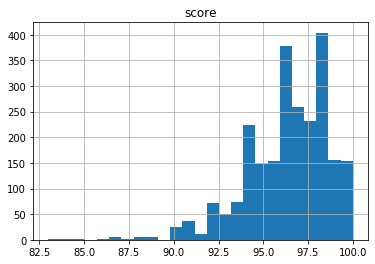

In [11]:
df_final.hist(column='score', bins=25)

It seems that most of our scores will be in the 90+ range, which is probably a good sign - restaurants are good at maintaining health standards, at least when it comes to health inspections. Now let's see if there is a correlation between the median income of a zip code, and the restaurant's score. I created a scatterplot that compares median household income to score.

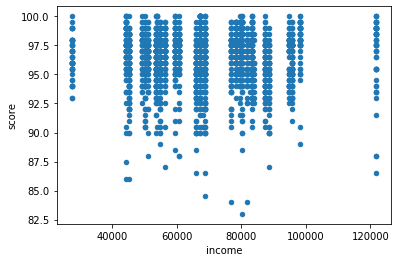

In [12]:
df_final.plot.scatter(x='income', y='score')

From a first glance, it seems that high and low ratings are fairly consistent across the board. My first guess would be to say that the mid-range incomes seem to have the lowest scores, but these could just be outliers. If anything, the lowest median income on the far left appears to perform better than its higher income counterparts. Let's group the income brackets and find the averages to visualize them even further (ignore the zip code average). 

In [13]:
df_final.groupby('income_bracket').mean()

,zip,score,income
income_bracket,,,
high,27531.71,96.12,96480.58
low,27604.16,96.84,38204.87
mid_high,27569.68,96.37,73293.72
mid_low,27598.42,96.33,52576.56


This disproves our hypothesis even further! Now that we can see each average score grouped by income, we can confirm that the scores are fairly consistent across all income brackets. Not just that, but the restaurants in the "low" income zip codes scored an average of 0.72 points higher than the "high" income zip code restaurants, even though the average "high" income is more than double that of the "low" income!

It would be really easy to stop here, but we should continue to analyze to make sure our results are conclusive. I want to build a model to predict score from income bracket, to truly determine the fate of our original hypothesis.

I created a 1-D linear model by fitting the values from our current dataframe to try and predict the score from income. For the values, I chose the lowest income as the lower bound and the highest income as the higher bound.

In [14]:
max_income = df_final['income'].max()
min_income = df_final['income'].min()

In [15]:
a1, b1 = np.polyfit(df_final.income, df_final.score, 1)
arr = np.arange(min_income, max_income)
pred_score_temp = [i * a1 + b1 for i in arr]
pred_score = np.asarray(pred_score_temp, dtype=float)

MAX prediction:  96.33210690562484
MIN prediction:  96.34734426924852
Variance:  1.934872004248926e-05


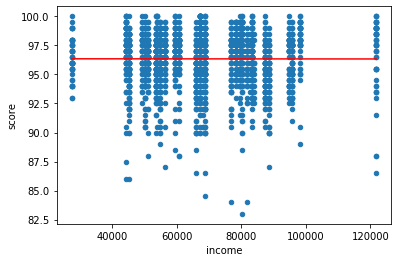

In [16]:
df_final.plot.scatter(x='income', y='score')
plt.plot(arr, pred_score, color='red')
print('MAX prediction: ', pred_score.min())
print('MIN prediction: ', pred_score.max())
print('Variance: ', stat.variance(pred_score))

Our scatterplot now displays our current data, along with a line that represents our predictions created from a model of that data. We also have our max and min predictions on display. As you can see, our model has an incredibly low variance, and our prediction line appears to be almost completely flat - detailing a steady, consistent set of values across all incomes. 

To be absolutely, positively sure, we can also use Ordinary Least Squares and patsy to create another linear model, predicting score from income.

In [17]:
score = df_final['score']
income = df_final['income']
outcome_1, predictors_1 = patsy.dmatrices('score ~ income', df_final)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [18]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003944
Date:                Sat, 06 Jun 2020   Prob (F-statistic):              0.950
Time:                        23:24:36   Log-Likelihood:                -5417.8
No. Observations:                2397   AIC:                         1.084e+04
Df Residuals:                    2395   BIC:                         1.085e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.3518      0.181    532.928      0.0

When considering our score, our income appears to not be a good indicator.

# Ethics & Privacy

For my research, I used the given datasets, which contained information on health inspections and restaurants. All of the information is publicly available, either provided by the government or by a third party (such as yelp) that is visible for anyone to see if they wish. Therefore, my project did not require any cleaning or hiding. I did not violate anyone's privacy by using a personal name, income, or any other personal information, and I did not manipulate the data in any way. My data and my analysis were both carried out in a very general manner. 

I understand that dealing with incomes and income brackets may be a sensitive topic for some. My project in no way had any intention in singling out or slandering any particular zip code or income level, and such information was only used in a purely research-oriented environment. No opinion or bias was given towards any particular data, and all research methods were carried out in compliance with ethical standards and privacy rules. 

# Conclusion & Discussion

My research shows that in the particular urban city of Raleigh, North Carolina and its surrounding suburbs, there appears to be no correlation between the average income of an area and the health inspection ratings its fast food restaurants receive. Any perception of poorer neighborhoods receiving poorer health inspection reviews is false and/or purely coincidental, and not consistent with the data that was gathered and explored. 

A very possible factor in this regard is brought up in this article*, in which the author explains that restaurants with poor sanitation standards can still receive high scores because of the way the scoring system works. Minor, but gross and unsanitary infractions, can result in a small deduction but may be reflected as something visually unappealing to the customer (ie. a dirty sink or dirty furniture). This can result in a negative perception of a restaurant, which is not reflected in neither its score nor its data used in the research. 

*https://www.sgvtribune.com/2015/06/25/what-that-restaurant-letter-grade-isnt-telling-you-about-health-and-cleanliness/

Then again, there may also be other factors to consider that were not carried out in this research environment. In particular, what about the number of critical infractions compared to the number of minor infractions, with the former weighing much more than the latter? Perhaps a better angle to determine the correlation between income and score would be to take into account those numbers as well and perform a multivariable regression analysis, or even using the description left by the inspector as sentiment, and weighing that along with the scores? And then, what about certain types of cuisines (pizza, burgers, sandwiches) that may tend to score lower or higher that can cause flunctuations in our graph?

There are indefinitely many approaches to this specific research question, and my research only touches the surface. The only real conclusion I can draw from my research is that we cannot draw any correlation between the income and the restaurant's score within a given zip code, but perhaps in the future more research can be carried out answering and taking the questions I mentioned above to give a more solid answer.